In [1]:
import random
import pennylane as qml
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import mne
from sklearn.model_selection import train_test_split
import math

print('Pennylane Version :', qml.__version__)
print('Pytorch Version :', torch.__version__)

/global/homes/j/junghoon/.local/perlmutter/python-3.11/lib/python3.11/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.34 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Pennylane Version : 0.41.1
Pytorch Version : 2.5.0+cu121


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


In [3]:
def set_all_seeds(seed: int = 42) -> None:
    """Seed every RNG we rely on (Python, NumPy, Torch, PennyLane, CUDNN)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)           # no-op on CPU
    torch.backends.cudnn.deterministic = True  # reproducible convolutions
    torch.backends.cudnn.benchmark = False
    os.environ["PL_GLOBAL_SEED"] = str(seed) 

# QCNN

In [4]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, n_layers=2, input_dim=784, num_classes=10):
        """
        QCNN with classical dimensionality reduction and variational embedding for multi-class classification.

        Args:
            n_qubits (int): Number of qubits.
            n_layers (int): Number of convolutional & pooling layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
            num_classes (int): Number of classes for classification.
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.num_classes = num_classes

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits)
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, features):
        wires = list(range(self.n_qubits))
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.n_layers):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)
        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(self.conv_params, self.pool_params, reduced_x)
        # Convert quantum output to logits for multi-class classification
        quantum_out = torch.stack(quantum_out, dim=1).float()
        return quantum_out

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

## Circuit Visualization

In [5]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)

In [6]:
# Quantum parameters
conv_params = nn.Parameter(torch.randn(n_layers, n_qubits, 15))
pool_params = nn.Parameter(torch.randn(n_layers, n_qubits // 2, 3))

# Quantum device initialization
dev = qml.device("default.qubit", wires=n_qubits)

def circuit(conv_weights, pool_weights, features):
    wires = list(range(n_qubits))
    # Variational Embedding (Angle Embedding)
    qml.AngleEmbedding(features, wires=wires, rotation='Y')
    for layer in range(n_layers):
        # Convolutional Layer
        _apply_convolution(conv_weights[layer], wires)
        # Pooling Layer
        _apply_pooling(pool_weights[layer], wires)
        wires = wires[::2]  # Retain every second qubit after pooling
    # Measurement: A single PauliZ to measure the state of the first qubit for binary classification
    return qml.expval(qml.PauliZ(n_qubits-1))

def _apply_convolution(weights, wires):
    """
    Convolutional layer logic (same as original).
    """
    n_wires = len(wires)
    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                qml.U3(*weights[indx, :3], wires=w)
                qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[indx, 9:12], wires=w)
                qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

def _apply_pooling(pool_weights, wires):
    # Pooling using a variational circuit
    n_wires = len(wires)
    assert n_wires >= 2, "Need at least two wires for pooling."
    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            measurement = qml.measure(w)
            qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

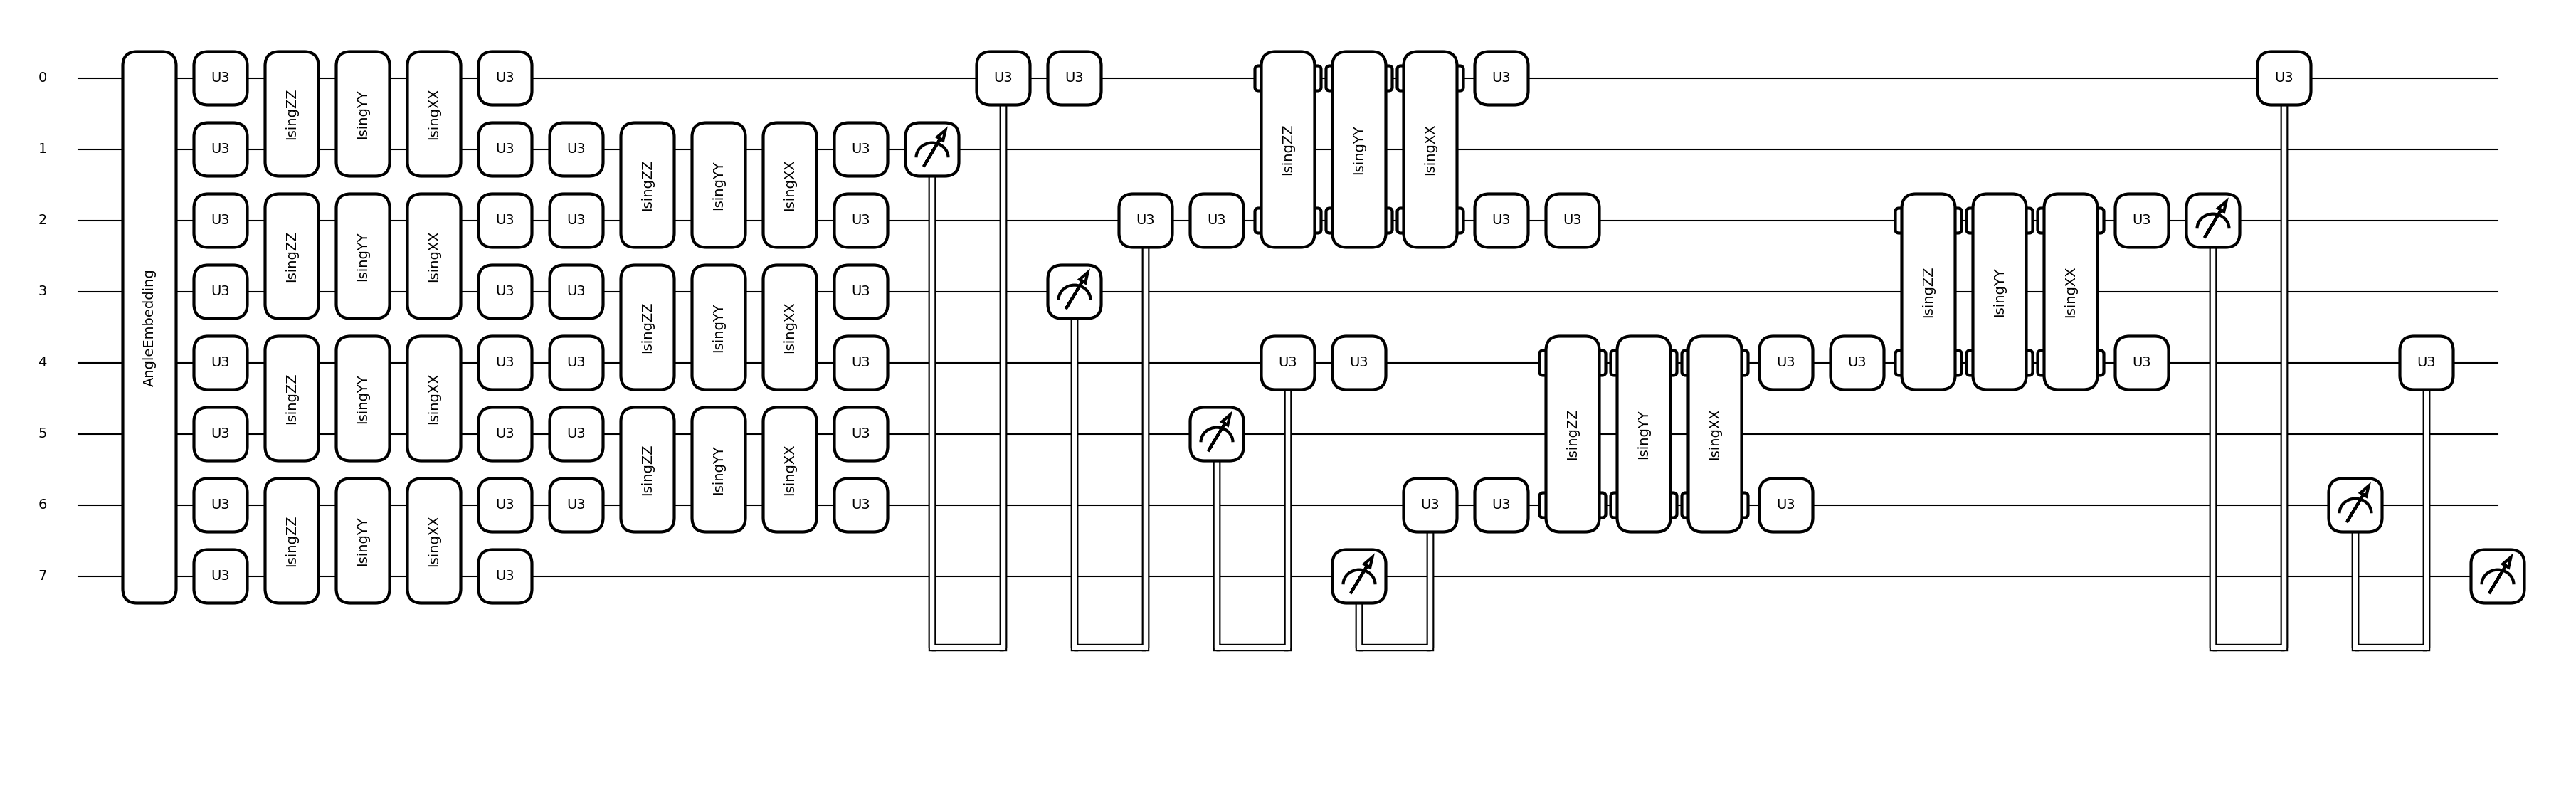

In [7]:
fig, ax = qml.draw_mpl(circuit)(conv_params, pool_params, classical_features)

# QTCN 1: QCNN + (Classical Dilation, Causal, Residual)

In [55]:
class QTCN(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size, dilation=1):
        super(QTCN, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        # The kernel size defines how many time steps we consider for the "convolution"
        self.input_channels = input_dim[1]
        self.time_steps = input_dim[2]
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # The input channels are treated as the feature size for each time step
        # Fully connected classical linear layer
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits)  # For dimension reduction
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification

    def circuit(self, features):
        wires = list(range(self.n_qubits))    
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            # Convolutional Layer
            self._apply_convolution(self.conv_params[layer], wires)
            # Pooling Layer
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        # Measurement
        return qml.expval(qml.PauliZ(self.n_qubits-1))

    def _apply_convolution(self, weights, wires):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."

        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])
                
    def forward(self, x):
        # x has shape (batch_size, time_steps, input_channels)
        batch_size, input_channels, time_steps = x.size()
        # Quantum Circuit Execution
        quantum_circuit = qml.QNode(self.circuit, self.dev)
        # Initialize an empty list to store the output
        output = []
        # Slide a window of size `kernel_size` across the time steps (with dilation)
        for i in range(self.dilation * (self.kernel_size - 1), time_steps):
            indices = [i - d*self.dilation for d in range(self.kernel_size)]
            indices.reverse()
            window = x[:, :, indices].reshape(batch_size, -1)
            reduced_window = self.fc(window)
            residual = x[:, :, -(self.kernel_size):].reshape(batch_size, -1)
            residual = self.downsample(residual)
            output.append(quantum_circuit(reduced_window+residual))
        # output = torch.stack(output, dim=1)
        # output = self.fc_out(output.float()).squeeze(1)
        output = torch.mean(torch.stack(output, dim=1), dim=1)
        return output

# QTCN 2: (QCNN+Quantum Dilation) + (Classical Causal, Residual)

In [8]:
class QTCN2(nn.Module):
    """
    Quantum Temporal Convolutional Network (QTCN) using a QCNN-style ansatz.

    This model processes spatio-temporal data by:
    1. Using a classical Conv1D layer for feature extraction.
    2. Processing a sliding window of data (receptive field) on a quantum circuit.
    3. Applying causal, dilated convolutions using a complex U3/Ising gate structure.
    4. Using a "conveyor belt" mechanism to stream through the time-series data.

    Args:
        input_channels (int): Number of features for each time step in the input data.
        receptive_field_size (int): The number of time steps the quantum circuit processes. This equals the number of qubits.
        n_layers (int): The number of stacked dilated convolutional layers.
    """

    def __init__(self, receptive_field_size=8, n_layers=3,  input_channels=64):
        super(QTCN2, self).__init__()

        if 2**(n_layers-1) > receptive_field_size:
            raise ValueError("The largest dilation factor (2**(n_layers-1)) cannot exceed the receptive field size.")

        self.receptive_field_size = receptive_field_size
        self.n_layers = n_layers
        self.input_channels = input_channels

        # 1. Classical Feature Extraction
        # This layer reduces the multiple input channels at each time step to a single feature.
        # This single feature will then be encoded into a qubit's angle.        
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=1,
            kernel_size=1
        )

        # 2. Quantum Parameters (MODIFIED)
        # Each layer now has a set of 15 shared parameters for the complex QCNN ansatz.
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))

        # 3. Quantum Device and QNode (Unchanged)
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

        # self.fc_out = nn.Linear(self.time_steps - self.dilation * (self.kernel_size - 1), 1)  # Final output layer for Binary Classification
        
    def _apply_dilated_conv(self, weights, dilation):
        """
        Applies a single layer of causal, dilated convolution using the QCNN ansatz.

        Args:
            weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
            dilation (int): The dilation factor (d).
        """
        # The 15 parameters are shared across all pairs in this layer,
        # achieving the "weight sharing" of a classical convolution.
        for i in range(self.receptive_field_size - dilation):
            # Define the pair of qubits for the dilated interaction
            w1 = i
            w2 = i + dilation

            # Apply the sequence of gates from the QCNN ansatz
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _circuit(self, features, conv_params):
        """
        The quantum circuit. The logic is the same, but it calls the new conv layer.

        Args:
            features (torch.Tensor): A tensor of size (receptive_field_size,).
            conv_params (torch.Tensor): The learnable parameters for all layers.
        """
        qml.AngleEmbedding(features, wires=range(self.receptive_field_size), rotation='Y')

        # Stack layers with exponentially growing dilations
        for layer_idx in range(self.n_layers):
            dilation = 2**layer_idx
            # Pass the correct set of 15 parameters for the current layer
            self._apply_dilated_conv(conv_params[layer_idx], dilation)

        return qml.expval(qml.PauliZ(self.receptive_field_size - 1))

    def forward(self, x):
        """
        The main forward pass implementing the "Conveyor Belt" (Unchanged).

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_channels, time_steps).
        Returns:
            torch.Tensor: A tensor of predictions, shape (batch_size, num_predictions).
        """
        batch_size = x.shape[0]
        time_steps = x.shape[2]

        if time_steps < self.receptive_field_size:
            raise ValueError(f"Input time steps ({time_steps}) must be at least as large as the receptive field ({self.receptive_field_size}).")

        x = self.feature_extractor(x)
        x = x.squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            sample_sequence = x[i]
            window = sample_sequence[:self.receptive_field_size].clone()
            sequence_predictions = []

            for t in range(time_steps - self.receptive_field_size + 1):
                q_out = self.qnode(window, self.conv_params)
                sequence_predictions.append(q_out)
                
                if t < time_steps - self.receptive_field_size:
                    window = torch.roll(window, shifts=-1, dims=0)
                    window[-1] = sample_sequence[t + self.receptive_field_size]

            batch_predictions.append(torch.stack(sequence_predictions))
        outputs = torch.mean(torch.stack(batch_predictions), dim=1)

        return outputs

## Circuit Visualization

In [66]:
n_qubits = 8
n_layers = 2
classical_features = np.random.rand(8)
conv_params = nn.Parameter(torch.randn(n_layers, 15))

In [67]:
def _apply_dilated_conv(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)

def _circuit(features, conv_params):
    """
    The quantum circuit. The logic is the same, but it calls the new conv layer.
    
    Args:
        features (torch.Tensor): A tensor of size (receptive_field_size,).
        conv_params (torch.Tensor): The learnable parameters for all layers.
    """
    qml.AngleEmbedding(features, wires=range(n_qubits), rotation='Y')
    # Stack layers with exponentially growing dilations
    for layer_idx in range(n_layers):
        dilation = 2**layer_idx
        # Pass the correct set of 15 parameters for the current layer
        _apply_dilated_conv(conv_params[layer_idx], dilation)

    return qml.expval(qml.PauliZ(n_qubits - 1))

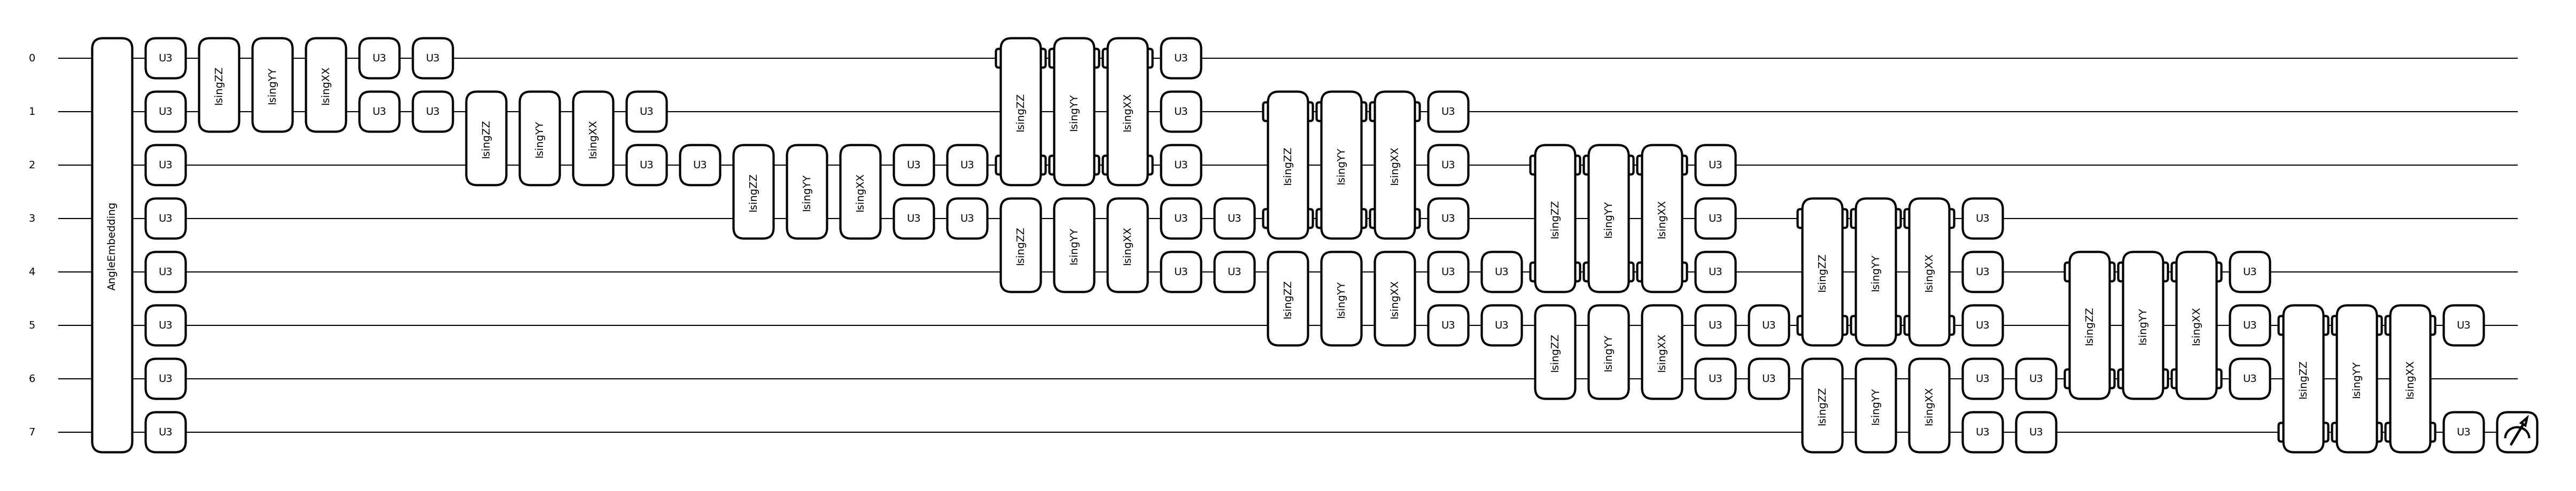

In [68]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

## ChatGPT Version

In [19]:
# -------------------------------------------------------------
# 1.  Imports
# -------------------------------------------------------------
import torch
import torch.nn as nn
import pennylane as qml
import math

# -------------------------------------------------------------
# 2.  Helper: one causal‑dilated layer (kernel size k = 2)
# -------------------------------------------------------------
def qcnn_dilated_layer(wires, theta15, dilation):
    """
    QCNN 15‑parameter kernel applied to every non‑overlapping pair
    (q_i, q_{i+dilation}) where i starts at parity p.
    The pattern mirrors your original _apply_convolution.
    """
    n = len(wires)

    # run two passes, parity p = 0 then p = 1, so that no qubit
    # participates twice in the same pass
    for p in [0, 1]:
        for i in range(n - dilation):
            # pick non‑overlapping pairs
            if (i % (2 * dilation) == p) and (i + dilation < n):
                qL, qR = wires[i], wires[i + dilation]

                # ----  QCNN kernel  ---------------------------------
                qml.U3(*theta15[0:3],  wires=qL)
                qml.U3(*theta15[3:6],  wires=qR)

                qml.IsingZZ(theta15[6],  wires=[qL, qR])
                qml.IsingYY(theta15[7],  wires=[qL, qR])
                qml.IsingXX(theta15[8],  wires=[qL, qR])

                qml.U3(*theta15[9:12],  wires=qL)
                qml.U3(*theta15[12:15], wires=qR)
                # -----------------------------------------------------

# -------------------------------------------------------------
# 3.  QTCN module
# -------------------------------------------------------------
class QTCN_GPT(nn.Module):
    """
    Quantum Temporal Convolutional Network with
    - dilated skip‑entangler convolutions
    - conveyor‑belt SWAP shift for strict causality
    """

    def __init__(
        self,
        n_qubits        : int   = 8,          # window length  R
        n_layers        : int   = 3,          # number of dilated conv layers
        dilations       : tuple = (1, 2, 4),  # can be customised
        in_channels     : int   = 64,         # EEG channels, for example
        time_steps      : int   = 128,        # full sequence length  T
        n_outputs       : int   = 1           # binary classification
    ):
        super().__init__()
        assert len(dilations) == n_layers, "dilations list must match n_layers"
        assert max(dilations) < n_qubits,     "dilation cannot exceed register"

        self.R          = n_qubits
        self.T          = time_steps
        self.dilations  = dilations
        self.n_layers   = n_layers
        self.n_outputs  = n_outputs

        # --- classical pre‑processing ---
        # Compress the C (channel) dimension down to one scalar per time‑step
        self.channel_reducer = nn.Linear(in_channels, 1)

        # --- shared quantum weights: one θ per layer (k = 2 kernel) ---
        #   If you prefer >1 parameter per layer, change causal_dilated_layer.
        self.theta = nn.Parameter(torch.randn(n_layers, 15) * 0.01)

        # PennyLane device
        self.dev = qml.device("default.qubit", wires=self.R)

        # Register the QNode once with Torch interface
        self.QNode = qml.QNode(self._circuit, self.dev)

    # ---------------------------------------------------------
    # 3.1  Quantum circuit   (one *entire* sequence per call)
    # ---------------------------------------------------------
    def _circuit(self, time_series, thetas):
        """
        Parameters
        ----------
        time_series : 1‑D Tensor of length T (already channel‑reduced)
        thetas      : 1‑D Tensor of length n_layers (trainable)
        """
        wires = list(range(self.R))

        # -------------------------------------------------
        # Step‑0  :  encode the *first R* samples
        # -------------------------------------------------
        qml.AngleEmbedding(time_series[0 : self.R], wires=wires, rotation="Y")

        # Convenience: pointer to the next sample to be ingested
        next_ptr = self.R

        # A list to collect logits per time‑step (optional)
        outputs = []

        # -------------------------------------------------
        # Step loop : stream through the remaining samples
        # -------------------------------------------------
        for t in range(self.R - 1, self.T):        # t indexes "current" time
            # (1) apply L dilated causal layers
            for l, d in enumerate(self.dilations):
                qcnn_dilated_layer(wires, thetas[l], dilation=d)

            # # (2) shift register & load next sample *unless* we're at last step
            # if t < self.T - 1:
            #     for q in range(self.R - 1):
            #         qml.SWAP(wires=[wires[q], wires[q + 1]])
            #     qml.RY(time_series[next_ptr] * 2 * math.pi, wires=wires[-1])
            #     next_ptr += 1

        # single measurement at the very end
        return qml.expval(qml.PauliZ(wires[-1]))                      # expval ∈ [‑1, +1]

    # ---------------------------------------------------------
    # 3.2  Forward pass  (batch × channels × time)
    # ---------------------------------------------------------
    def forward(self, x):
        """
        x shape: (batch, channels, time_steps)
        """
        B, C, T = x.shape
        assert T == self.T, "Sequence length must match time_steps"

        # (i) channel reduction  (vectorised: B × T × 1)
        #     Permute so Linear sees the channel dim last.
        x_reduced = self.channel_reducer(x.permute(0, 2, 1)).squeeze(-1)

        # (ii) run the quantum circuit *sample‑by‑sample* (batch loop)
        logits = []
        for b in range(B):
            logits.append(self.QNode(x_reduced[b], self.theta))

        logits = torch.stack(logits)          # shape (B,)
        # Map ⟨Z⟩ ∈ [‑1,1] to logit:   logit = α·⟨Z⟩ + β   (learnable if desired)
        return logits           

In [45]:
R = 8
T = 10
n_layers = 3
classical_features = np.random.rand(12)
# --- shared quantum weights: one θ per layer (k = 2 kernel) ---
#   If you prefer >1 parameter per layer, change causal_dilated_layer.
theta = nn.Parameter(torch.randn(n_layers, 15) * 0.01)
dilations = (1, 2)

In [46]:
# -------------------------------------------------------------
# 2.  Helper: one causal‑dilated layer (kernel size k = 2)
# -------------------------------------------------------------
def qcnn_dilated_layer(wires, theta15, dilation):
    """
    QCNN 15‑parameter kernel applied to every non‑overlapping pair
    (q_i, q_{i+dilation}) where i starts at parity p.
    The pattern mirrors your original _apply_convolution.
    """
    n = len(wires)

    # run two passes, parity p = 0 then p = 1, so that no qubit
    # participates twice in the same pass
    for p in [0, 1]:
        for i in range(n - dilation):
            # pick non‑overlapping pairs
            if (i % (2 * dilation) == p) and (i + dilation < n):
                qL, qR = wires[i], wires[i + dilation]

                # ----  QCNN kernel  ---------------------------------
                qml.U3(*theta15[0:3],  wires=qL)
                qml.U3(*theta15[3:6],  wires=qR)

                qml.IsingZZ(theta15[6],  wires=[qL, qR])
                qml.IsingYY(theta15[7],  wires=[qL, qR])
                qml.IsingXX(theta15[8],  wires=[qL, qR])

                qml.U3(*theta15[9:12],  wires=qL)
                qml.U3(*theta15[12:15], wires=qR)
                # -----------------------------------------------------
                
# ---------------------------------------------------------
# 3.1  Quantum circuit   (one *entire* sequence per call)
# ---------------------------------------------------------
def _circuit(time_series, thetas):
    """
    Parameters
    ----------
    time_series : 1‑D Tensor of length T (already channel‑reduced)
    thetas      : 1‑D Tensor of length n_layers (trainable)
    """
    wires = list(range(R))
    # -------------------------------------------------
    # Step‑0  :  encode the *first R* samples
    # -------------------------------------------------
    qml.AngleEmbedding(time_series[0 : R], wires=wires, rotation="Y")

    # Convenience: pointer to the next sample to be ingested
    next_ptr = R
    # A list to collect logits per time‑step (optional)
    outputs = []

    # -------------------------------------------------
    # Step loop : stream through the remaining samples
    # -------------------------------------------------
    for t in range(R - 1, T):        # t indexes "current" time
        # (1) apply L dilated causal layers
        for l, d in enumerate(dilations):
            qcnn_dilated_layer(wires, thetas[l], dilation=d)

       # (2) shift register & load next sample *unless* we're at last step
        if t < T - 1:
            for q in range(R - 1):
                qml.SWAP(wires=[wires[q], wires[q + 1]])
            qml.RY(time_series[next_ptr] * 2 * math.pi, wires=wires[-1])
            next_ptr += 1

    # single measurement at the very end
    return qml.expval(qml.PauliZ(wires[-1]))                      # expval ∈ [‑1, +1]

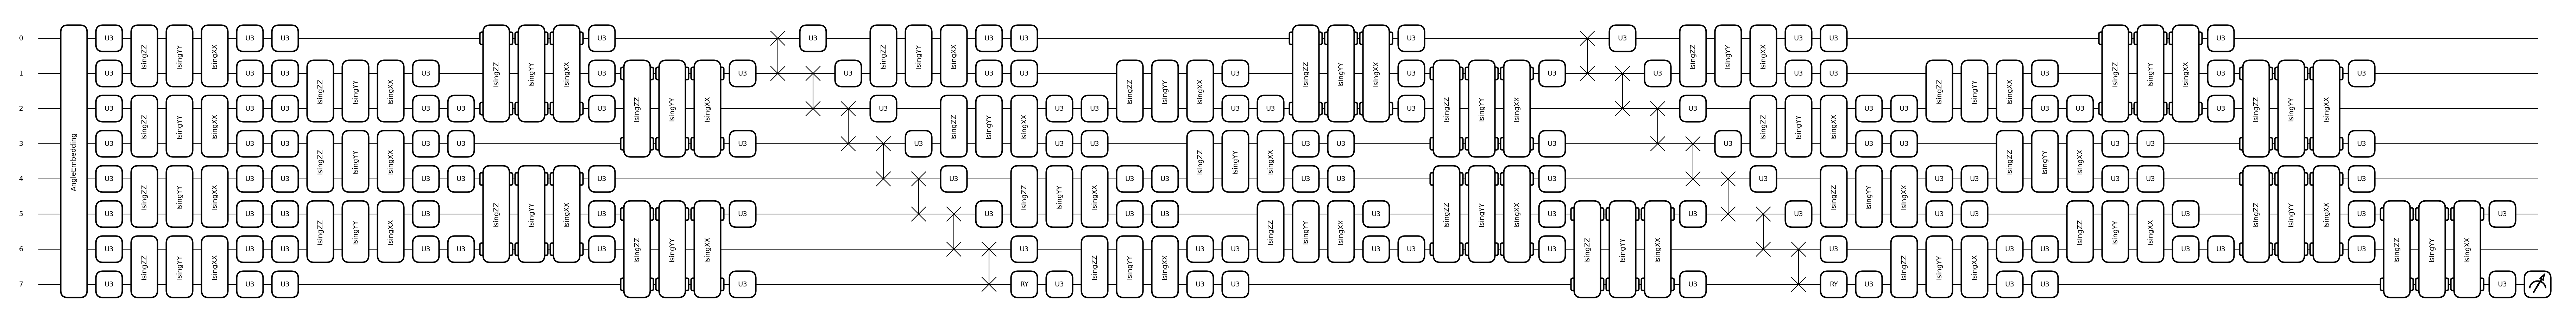

In [47]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

# QTCN 3: (QCNN + Quantum Dilation, Causal) + Classical Residual

In [9]:
class QTCN3(nn.Module):
    """
    (THEORETICAL MODEL)
    Quantum Temporal Convolutional Network with a physical Quantum SWAP Chain.

    WARNING: This model is for educational purposes only and is not practical
    on any near-term quantum hardware due to extreme noise and circuit depth.

    It processes an entire time-series within a single, stateful quantum circuit,
    using qml.SWAP gates to implement the "conveyor belt".

    Args:
        input_channels (int): Number of features for each time step.
        receptive_field_size (int): The number of qubits, defining the processing window.
        n_layers (int): The number of stacked dilated convolutional layers.
        time_steps (int): The total number of time steps in the input sequence.
    """

    def __init__(self, receptive_field_size=8, n_layers=3, input_channels=64, time_steps=20):
        super(QTCN3, self).__init__()
        
        # Validate that the model is runnable
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")
        if 2**(n_layers-1) > receptive_field_size:
            raise ValueError("The largest dilation factor cannot exceed the receptive field size.")

        self.receptive_field_size = receptive_field_size
        self.n_layers = n_layers
        self.input_channels = input_channels
        self.time_steps = time_steps

        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=1,
            kernel_size=1
        )

        # 2. Quantum Parameters (Unchanged)
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # 3. Quantum Device and QNode
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)        
        # The QNode now encapsulates the entire temporal evolution
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

    def _apply_dilated_conv(self, weights, dilation):
        """Applies a single layer of dilated convolution using the QCNN ansatz (Unchanged)."""
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = i, i + dilation
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)
            
    def _apply_swap_shift(self):
        """
        Applies a chain of SWAP gates to shift the quantum state one step to the next.
        q_state[i] -> q_state[i+1].
        """
        # shift the register left by one → conveyor‑belt SWAPs
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[i, i+1])

    def _circuit(self, full_sequence, conv_params):
        """
        A single, giant quantum circuit that processes an entire time series.
        
        Args:
            full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
            conv_params (torch.Tensor): The learnable parameters for all layers.
        """
        # 1. Initialize the circuit by encoding the first full window
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=range(self.receptive_field_size), rotation='Y')

        # This will hold the expectation value from each time step
        predictions = []

        # 2. Main temporal loop WITHIN the quantum circuit
        for t in range(self.time_steps - self.receptive_field_size + 1):
            # A. Apply the dilated convolutional layers to the current state
            for layer_idx in range(self.n_layers):
                dilation = 2**layer_idx
                self._apply_dilated_conv(conv_params[layer_idx], dilation)
            
            # B. If not the last step, perform the physical quantum SWAP shift
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                
                # C. Encode the next new data point onto the now "vacant" last qubit
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.receptive_field_size - 1)
        
        # D. Measure the last qubit at the very end
        return qml.expval(qml.PauliZ(self.receptive_field_size-1))
    
    def forward(self, x):
        """
        The forward pass is now much simpler classically, as all temporal logic
        is inside the quantum circuit.
        """
        batch_size = x.shape[0]

        # Classically pre-process the data
        x = self.feature_extractor(x)
        x = x.squeeze(1)  # Shape becomes (batch_size, time_steps)

        # Loop over the batch, running the full quantum evolution for each sample
        batch_predictions = []
        for i in range(batch_size):
            # The qnode returns a list/tuple of scalar tensors
            predictions_for_sample = self.qnode(x[i], self.conv_params)
            # Stack them into a single tensor for this sample
            batch_predictions.append(predictions_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [63]:
receptive_field_size = 8
n_layers = 2
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
time_steps=10

In [64]:
def _apply_dilated_conv(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)


def _apply_swap_shift():
    """
    Applies a chain of SWAP gates to shift the quantum state one step to the left.
    q_state[i] -> q_state[i-1].
    """
    # shift the register left by one → conveyor‑belt SWAPs
    for i in range(receptive_field_size - 1):
        qml.SWAP(wires=[i, i+1])


def _circuit(full_sequence, conv_params):
    """
    A single, giant quantum circuit that processes an entire time series.
        
    Args:
        full_sequence (torch.Tensor): The full, pre-processed time series for ONE sample.
        conv_params (torch.Tensor): The learnable parameters for all layers.
    """
    # 1. Initialize the circuit by encoding the first full window
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=range(receptive_field_size), rotation='Y')

    # This will hold the expectation value from each time step
    predictions = []

    # 2. Main temporal loop WITHIN the quantum circuit
    for t in range(time_steps - receptive_field_size + 1):
        # A. Apply the dilated convolutional layers to the current state
        for layer_idx in range(n_layers):
            dilation = 2**layer_idx
            _apply_dilated_conv(conv_params[layer_idx], dilation)
            
        # B. If not the last step, perform the physical quantum SWAP shift
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
                
            # C. Encode the next new data point onto the now "vacant" last qubit
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=receptive_field_size - 1)
        
    # D. Measure the last qubit at the very end
    return qml.expval(qml.PauliZ(receptive_field_size-1))

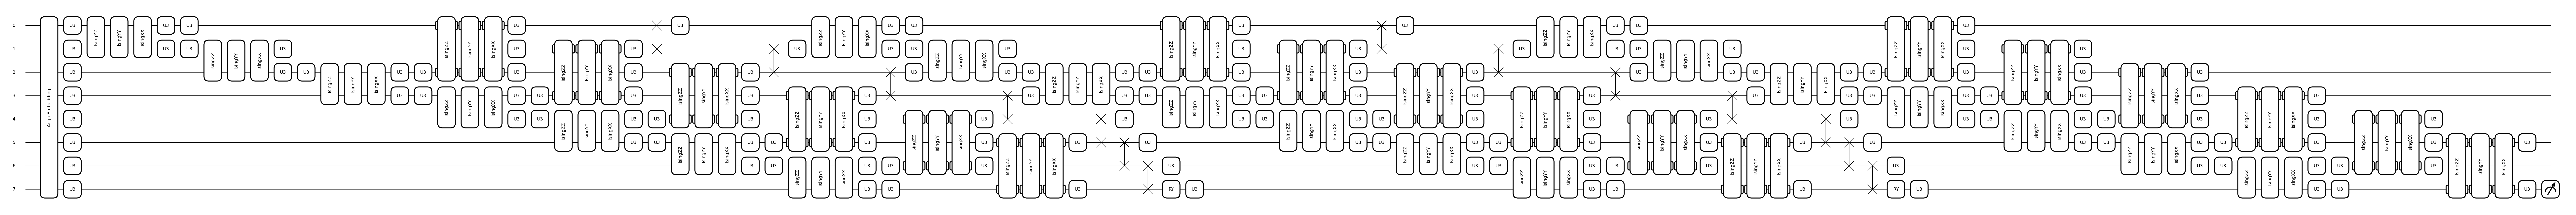

In [65]:
fig, ax = qml.draw_mpl(_circuit)(classical_features, conv_params)

# QTCN 4: QCNN + Quantum Dilation, Causal, Residual

In [10]:
class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))

        
class QTCN4(nn.Module):
    """
    (THEORETICAL MODEL)
    QTCN with physical Quantum SWAP Chains and Quantum Residual Blocks.

    This version adds an ancilla qubit to control the application of each
    convolutional block, creating a quantum analogue of a residual connection.
    """
    def __init__(self, receptive_field_size=8, n_residual_blocks=3, input_channels=64, time_steps=20):
        super().__init__()
        
        if time_steps < receptive_field_size:
            raise ValueError("Total time_steps must be >= receptive_field_size.")

        self.receptive_field_size = receptive_field_size
        self.n_residual_blocks = n_residual_blocks
        self.input_channels = input_channels
        self.time_steps = time_steps

        # Main processing wires and a dedicated ancilla for residual control
        self.main_wires = list(range(receptive_field_size))
        self.ancilla_wire = receptive_field_size # The last qubit is the ancilla
        
        # 1. Classical Feature Extraction
        self.feature_extractor = nn.Conv1d(
            in_channels=self.input_channels, out_channels=1, kernel_size=1)

        # 2. Quantum Residual Blocks
        # Create a list of residual blocks, each with its own learnable parameters.
        # The dilation factor will be determined by the block's index.
        self.residual_blocks = nn.ModuleList(
            [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
        )

        # 3. Quantum Device and QNode
        # The number of qubits is now receptive_field_size + 1 (for the ancilla)
        self.dev = qml.device("default.qubit", wires=receptive_field_size + 1)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch")

    def _apply_conv_ansatz(self, weights, dilation):
        """The core U3/Ising convolution ansatz (our 'F' transformation)."""
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = self.main_wires[i], self.main_wires[i + dilation]
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _apply_residual_block(self, block, dilation):
        """Applies a full residual block using ancilla control."""
        # 1. Put ancilla into a superposition controlled by the learnable parameter
        qml.RY(block.residual_param[0], wires=self.ancilla_wire)
        # 2. Apply the convolution, controlled by the ancilla
        # The 'qml.ctrl' function makes an operation conditional on a control qubit.
        qml.ctrl(self._apply_conv_ansatz, control=self.ancilla_wire)(block.conv_params[0], dilation)
        # 3. Uncompute the rotation on the ancilla to disentangle it
        qml.RY(-block.residual_param[0], wires=self.ancilla_wire)

    def _apply_swap_shift(self):
        """Applies a SWAP chain to the main processing wires only."""
        # shift the register left by one → conveyor‑belt SWAPs
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[self.main_wires[i], self.main_wires[i+1]])    

    def _circuit(self, full_sequence):
        """The main quantum circuit with residual blocks."""
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=self.main_wires)
        predictions = []
        for t in range(self.time_steps - self.receptive_field_size + 1):
            # Apply the stack of residual blocks
            for block_idx, block in enumerate(self.residual_blocks):
                dilation = 2**block_idx
                if dilation >= self.receptive_field_size: continue # Skip if dilation is too large
                self._apply_residual_block(block, dilation)
            # If not the last step, shift the state and encode the next sample
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.main_wires[-1])
        # Measure the last main qubit
        return qml.expval(qml.PauliZ(self.main_wires[-1]))
    
    def forward(self, x):
        """The forward pass."""
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            predictions_for_sample = self.qnode(x[i])
            batch_predictions.append(predictions_for_sample)

        return torch.stack(batch_predictions)

## Circuit Visualization

In [60]:
receptive_field_size = 8
n_layers = 2
n_residual_blocks = 1
classical_features = np.random.rand(10)
conv_params = nn.Parameter(torch.randn(n_layers, 15))
time_steps=10

In [61]:
main_wires = list(range(receptive_field_size))
residual_blocks = nn.ModuleList(
    [QuantumResidualBlock(n_layers=1) for _ in range(n_residual_blocks)]
)
ancilla_wire = receptive_field_size # The last qubit is the ancilla

class QuantumResidualBlock(nn.Module):
    """A single quantum residual block."""
    def __init__(self, n_layers=1):
        super().__init__()
        # The transformation 'F' is a stack of dilated convolutions.
        # For simplicity, we'll use n_layers=1 here, meaning one dilation per block.
        # Parameters for the U3/Ising-based convolution
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        # The learnable parameter 'alpha' that controls the residual connection
        self.residual_param = nn.Parameter(torch.randn(1))
        
def _apply_conv_ansatz(weights, dilation):
    """
    Applies a single layer of causal, dilated convolution using the QCNN ansatz.

    Args:
        weights (torch.Tensor): The learnable parameters for this layer, shape (15,).
        dilation (int): The dilation factor (d).
    """
    # The 15 parameters are shared across all pairs in this layer,
    # achieving the "weight sharing" of a classical convolution.
    for i in range(n_qubits - dilation):
        # Define the pair of qubits for the dilated interaction
        w1 = i
        w2 = i + dilation

        # Apply the sequence of gates from the QCNN ansatz
        qml.U3(*weights[:3], wires=w1)
        qml.U3(*weights[3:6], wires=w2)
        qml.IsingZZ(weights[6], wires=[w1, w2])
        qml.IsingYY(weights[7], wires=[w1, w2])
        qml.IsingXX(weights[8], wires=[w1, w2])
        qml.U3(*weights[9:12], wires=w1)
        qml.U3(*weights[12:15], wires=w2)


def _apply_swap_shift():
    """
    Applies a chain of SWAP gates to shift the quantum state one step to the left.
    q_state[i] -> q_state[i-1].
    """
    # Must loop from right to left to avoid overwriting states before they are swapped.
    for i in range(receptive_field_size - 1):
        qml.SWAP(wires=[i, i+1])

def _apply_residual_block(block, dilation):
    """Applies a full residual block using ancilla control."""
    # 1. Put ancilla into a superposition controlled by the learnable parameter
    qml.RY(block.residual_param[0], wires=ancilla_wire)
    # 2. Apply the convolution, controlled by the ancilla
    # The 'qml.ctrl' function makes an operation conditional on a control qubit.
    qml.ctrl(_apply_conv_ansatz, control=ancilla_wire)(block.conv_params[0], dilation)
    # 3. Uncompute the rotation on the ancilla to disentangle it
    qml.RY(-block.residual_param[0], wires=ancilla_wire)

def _circuit(full_sequence):
    """The main quantum circuit with residual blocks."""
    initial_window = full_sequence[:receptive_field_size]
    qml.AngleEmbedding(initial_window, wires=main_wires)
    predictions = []
    for t in range(time_steps - receptive_field_size + 1):
        # Apply the stack of residual blocks
        for block_idx, block in enumerate(residual_blocks):
            dilation = 2**block_idx
            if dilation >= receptive_field_size: continue # Skip if dilation is too large
            _apply_residual_block(block, dilation)
        # If not the last step, shift the state and encode the next sample
        if t < time_steps - receptive_field_size:
            _apply_swap_shift()
            next_sample = full_sequence[t + receptive_field_size]
            qml.RY(next_sample, wires=main_wires[-1])
    # Measure the last main qubit
    return qml.expval(qml.PauliZ(main_wires[-1]))

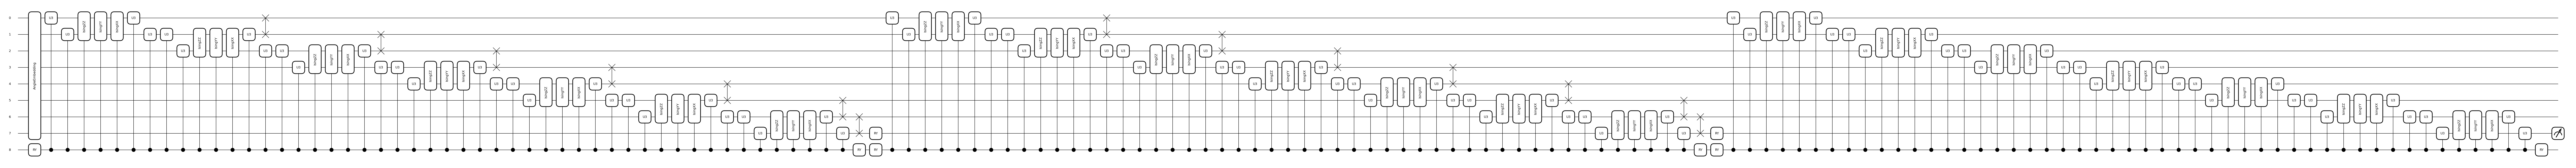

In [62]:
fig, ax = qml.draw_mpl(_circuit)(classical_features)

# Prepare PhysioNet EEG Dataset

Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004. https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

In [11]:
def load_eeg_ts(seed, device, batch_size, sampling_freq):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Load and preprocess the PhysioNet EEG Motor Imagery data
    N_SUBJECT = 50
    IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

    # Load data from PhysioNet (example assumes data is downloaded locally)
    physionet_paths = [
        mne.datasets.eegbci.load_data(
            subjects=subj_id,
            runs=IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
            path="PhysioNet_EEG",
        ) for subj_id in range(1, N_SUBJECT+1)
    ]
    physionet_paths = np.concatenate(physionet_paths)

    # Ensuring that all subjects share same sampling frequency
    # TARGET_SFREQ = 160  # 160 Hz sampling rate
    TARGET_SFREQ = sampling_freq

    # Concatenate all loaded raw data
    parts = []
    for path in physionet_paths:
        raw = mne.io.read_raw_edf(
            path,
            preload=True,
            stim_channel='auto',
            verbose='WARNING',
        )
        # Resample raw data to ensure consistent sfreq
        raw.resample(TARGET_SFREQ, npad="auto")
        parts.append(raw)
        
    # Concatenate resampled raw data
    raw = mne.concatenate_raws(parts)

    # Pick EEG channels and extract events
    eeg_channel_inds = mne.pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
    )
    events, _ = mne.events_from_annotations(raw)

    # Epoch the data
    epoched = mne.Epochs(
        raw, events, dict(left=2, right=3), tmin=1, tmax=4.1,
        proj=False, picks=eeg_channel_inds, baseline=None, preload=True
    )

    # Convert data to NumPy arrays
    X = (epoched.get_data() * 1e3).astype(np.float32)  # Convert to millivolts
    y = (epoched.events[:, 2] - 2).astype(np.int64)  # 0: left, 1: right
    
    # Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    def MakeTensorDataset(X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        tensordataset = TensorDataset(X_tensor, y_tensor)
        return tensordataset
    
    # Create datasets and dataloaders
    train_dataset = MakeTensorDataset(X_train, y_train)
    val_dataset = MakeTensorDataset(X_val, y_val)
    test_dataset = MakeTensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape
    
    return train_loader, val_loader, test_loader, input_dim

# Train & Evaluation Functions

In [12]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

In [13]:
def QuantumTCNN_run(model_type, n_qubits, circuit_depth, input_dim, kernel_size=None, dilation=None, num_epochs=10):
    print("Running on ", device)
    if model_type==1:
        model = QTCN(n_qubits, circuit_depth, input_dim, kernel_size, dilation).to(device)
    elif model_type==2:
        model = QTCN2(n_qubits, circuit_depth, input_dim[1]).to(device)
    elif model_type==3:
        model = QTCN3(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    elif model_type==4:
        model = QTCN4(n_qubits, circuit_depth, input_dim[1], input_dim[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN{model_type}_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [33]:
def QuantumTCNN_GPT_run(n_qubits, circuit_depth, input_dim, num_epochs):
    print("Running on ", device)
    model = QTCN_GPT(n_qubits=n_qubits, n_layers=circuit_depth, 
                  dilations=(1, 2), in_channels=input_dim[1], time_steps=input_dim[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumTCNN_GPT_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

# Load Dataset

In [14]:
train_loader, val_loader, test_loader, input_dim = load_eeg_ts(seed=2025, device=device, batch_size=32, sampling_freq=4)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
Using data from preloaded Raw for 2250 events and 13 original time points ...
116 bad epochs dropped


In [15]:
input_dim

(1493, 64, 13)

# Run Models

In [36]:
QuantumTCNN_run(model_type=1, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Epoch: 01 | Time: 0m 14s
Train Loss: 0.6941, AUC: 0.5163 | Validation Loss: 0.6934, AUC: 0.5844


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Epoch: 02 | Time: 0m 13s
Train Loss: 0.6924, AUC: 0.5637 | Validation Loss: 0.6926, AUC: 0.6100


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Epoch: 03 | Time: 0m 13s
Train Loss: 0.6898, AUC: 0.6472 | Validation Loss: 0.6915, AUC: 0.6226


100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Epoch: 04 | Time: 0m 13s
Train Loss: 0.6858, AUC: 0.6775 | Validation Loss: 0.6899, AUC: 0.6308


100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Epoch: 05 | Time: 0m 13s
Train Loss: 0.6794, AUC: 0.6926 | Validation Loss: 0.6863, AUC: 0.6387


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Epoch: 06 | Time: 0m 13s
Train Loss: 0.6710, AUC: 0.7043 | Validation Loss: 0.6815, AUC: 0.6560


100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Epoch: 07 | Time: 0m 13s
Train Loss: 0.6618, AUC: 0.7238 | Validation Loss: 0.6797, AUC: 0.6568


100%|██████████| 10/10 [00:01<00:00,  8.08it/s]


Epoch: 08 | Time: 0m 13s
Train Loss: 0.6509, AUC: 0.7315 | Validation Loss: 0.6729, AUC: 0.6687


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Epoch: 09 | Time: 0m 14s
Train Loss: 0.6401, AUC: 0.7518 | Validation Loss: 0.6665, AUC: 0.6873


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Epoch: 10 | Time: 0m 13s
Train Loss: 0.6285, AUC: 0.7627 | Validation Loss: 0.6615, AUC: 0.6950


100%|██████████| 11/11 [00:01<00:00,  8.12it/s]

Test Loss: 0.6337, AUC: 0.7381
Metrics saved to QuantumTCNN1_performance.csv


(0.6337125518105247, 0.7381215469613259)

In [56]:
QuantumTCNN_run(model_type=1, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=6, dilation=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Epoch: 01 | Time: 0m 14s
Train Loss: 0.6914, AUC: 0.5745 | Validation Loss: 0.6922, AUC: 0.6308


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Epoch: 02 | Time: 0m 14s
Train Loss: 0.6844, AUC: 0.6655 | Validation Loss: 0.6901, AUC: 0.6335


100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Epoch: 03 | Time: 0m 14s
Train Loss: 0.6784, AUC: 0.6940 | Validation Loss: 0.6879, AUC: 0.6573


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Epoch: 04 | Time: 0m 14s
Train Loss: 0.6730, AUC: 0.7072 | Validation Loss: 0.6857, AUC: 0.6626


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Epoch: 05 | Time: 0m 14s
Train Loss: 0.6684, AUC: 0.7197 | Validation Loss: 0.6829, AUC: 0.6813


100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Epoch: 06 | Time: 0m 14s
Train Loss: 0.6637, AUC: 0.7311 | Validation Loss: 0.6807, AUC: 0.6829


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Epoch: 07 | Time: 0m 14s
Train Loss: 0.6601, AUC: 0.7403 | Validation Loss: 0.6788, AUC: 0.6885


100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Epoch: 08 | Time: 0m 14s
Train Loss: 0.6567, AUC: 0.7487 | Validation Loss: 0.6765, AUC: 0.6907


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Epoch: 09 | Time: 0m 14s
Train Loss: 0.6530, AUC: 0.7515 | Validation Loss: 0.6738, AUC: 0.6937


100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Epoch: 10 | Time: 0m 16s
Train Loss: 0.6497, AUC: 0.7550 | Validation Loss: 0.6719, AUC: 0.6962


100%|██████████| 11/11 [00:01<00:00,  8.21it/s]

Test Loss: 0.6497, AUC: 0.7295
Metrics saved to QuantumTCNN1_performance.csv


(0.649661817333915, 0.7294790844514601)

In [16]:
QuantumTCNN_run(model_type=2, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


Epoch: 01 | Time: 21m 27s
Train Loss: 0.6935, AUC: 0.5057 | Validation Loss: 0.6931, AUC: 0.5736


100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


Epoch: 02 | Time: 21m 10s
Train Loss: 0.6931, AUC: 0.5019 | Validation Loss: 0.6930, AUC: 0.5859


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


Epoch: 03 | Time: 21m 20s
Train Loss: 0.6926, AUC: 0.5464 | Validation Loss: 0.6930, AUC: 0.5879


100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


Epoch: 04 | Time: 21m 21s
Train Loss: 0.6923, AUC: 0.5689 | Validation Loss: 0.6929, AUC: 0.5917


100%|██████████| 10/10 [01:44<00:00, 10.43s/it]


Epoch: 05 | Time: 21m 16s
Train Loss: 0.6920, AUC: 0.5448 | Validation Loss: 0.6929, AUC: 0.5985


100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


Epoch: 06 | Time: 21m 28s
Train Loss: 0.6912, AUC: 0.6038 | Validation Loss: 0.6928, AUC: 0.6015


100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


Epoch: 07 | Time: 21m 18s
Train Loss: 0.6905, AUC: 0.6217 | Validation Loss: 0.6926, AUC: 0.6068


100%|██████████| 10/10 [01:45<00:00, 10.53s/it]


Epoch: 08 | Time: 21m 31s
Train Loss: 0.6899, AUC: 0.6269 | Validation Loss: 0.6925, AUC: 0.6091


100%|██████████| 10/10 [01:44<00:00, 10.44s/it]


Epoch: 09 | Time: 21m 44s
Train Loss: 0.6893, AUC: 0.6287 | Validation Loss: 0.6922, AUC: 0.6139


100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


Epoch: 10 | Time: 21m 25s
Train Loss: 0.6885, AUC: 0.6361 | Validation Loss: 0.6921, AUC: 0.6155


100%|██████████| 11/11 [01:42<00:00,  9.36s/it]

Test Loss: 0.6909, AUC: 0.6675
Metrics saved to QuantumTCNN2_performance.csv


(0.6909329349344427, 0.6674822415153907)

In [17]:
QuantumTCNN_run(model_type=3, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


Epoch: 01 | Time: 20m 47s
Train Loss: 0.6930, AUC: 0.4911 | Validation Loss: 0.6933, AUC: 0.5377


100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


Epoch: 02 | Time: 20m 40s
Train Loss: 0.6928, AUC: 0.5250 | Validation Loss: 0.6932, AUC: 0.5548


100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


Epoch: 03 | Time: 20m 45s
Train Loss: 0.6928, AUC: 0.5150 | Validation Loss: 0.6932, AUC: 0.5638


100%|██████████| 10/10 [01:38<00:00,  9.85s/it]


Epoch: 04 | Time: 20m 46s
Train Loss: 0.6922, AUC: 0.5489 | Validation Loss: 0.6930, AUC: 0.5803


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


Epoch: 05 | Time: 21m 2s
Train Loss: 0.6918, AUC: 0.5620 | Validation Loss: 0.6927, AUC: 0.5908


100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


Epoch: 06 | Time: 20m 40s
Train Loss: 0.6911, AUC: 0.5781 | Validation Loss: 0.6924, AUC: 0.5984


100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


Epoch: 07 | Time: 20m 52s
Train Loss: 0.6903, AUC: 0.5981 | Validation Loss: 0.6922, AUC: 0.6086


100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


Epoch: 08 | Time: 20m 55s
Train Loss: 0.6897, AUC: 0.6119 | Validation Loss: 0.6917, AUC: 0.6119


100%|██████████| 10/10 [01:45<00:00, 10.57s/it]


Epoch: 09 | Time: 21m 12s
Train Loss: 0.6886, AUC: 0.6322 | Validation Loss: 0.6911, AUC: 0.6201


100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


Epoch: 10 | Time: 21m 11s
Train Loss: 0.6878, AUC: 0.6349 | Validation Loss: 0.6904, AUC: 0.6255


100%|██████████| 11/11 [01:42<00:00,  9.29s/it]

Test Loss: 0.6885, AUC: 0.6686
Metrics saved to QuantumTCNN3_performance.csv


(0.6884534467350353, 0.6685872138910812)

In [18]:
QuantumTCNN_run(model_type=4, n_qubits=8, circuit_depth=2, input_dim=input_dim, kernel_size=None, dilation=None, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [04:00<00:00, 24.08s/it]


Epoch: 01 | Time: 36m 12s
Train Loss: 0.7622, AUC: 0.5020 | Validation Loss: 0.7534, AUC: 0.5734


100%|██████████| 10/10 [04:03<00:00, 24.30s/it]


Epoch: 02 | Time: 36m 18s
Train Loss: 0.7389, AUC: 0.5029 | Validation Loss: 0.7274, AUC: 0.5742


100%|██████████| 10/10 [04:00<00:00, 24.10s/it]


Epoch: 03 | Time: 36m 0s
Train Loss: 0.7144, AUC: 0.5062 | Validation Loss: 0.7051, AUC: 0.5621


100%|██████████| 10/10 [03:57<00:00, 23.73s/it]


Epoch: 04 | Time: 35m 30s
Train Loss: 0.6998, AUC: 0.5012 | Validation Loss: 0.6967, AUC: 0.5382


100%|██████████| 10/10 [03:58<00:00, 23.80s/it]


Epoch: 05 | Time: 35m 41s
Train Loss: 0.6949, AUC: 0.5135 | Validation Loss: 0.6942, AUC: 0.5395


100%|██████████| 10/10 [03:59<00:00, 23.92s/it]


Epoch: 06 | Time: 35m 26s
Train Loss: 0.6937, AUC: 0.5027 | Validation Loss: 0.6933, AUC: 0.5422


100%|██████████| 10/10 [04:01<00:00, 24.16s/it]


Epoch: 07 | Time: 35m 22s
Train Loss: 0.6935, AUC: 0.4903 | Validation Loss: 0.6935, AUC: 0.5525


100%|██████████| 10/10 [03:56<00:00, 23.70s/it]


Epoch: 08 | Time: 35m 36s
Train Loss: 0.6938, AUC: 0.5093 | Validation Loss: 0.6926, AUC: 0.5440


100%|██████████| 10/10 [03:52<00:00, 23.24s/it]


Epoch: 09 | Time: 35m 9s
Train Loss: 0.6930, AUC: 0.5054 | Validation Loss: 0.6925, AUC: 0.5464


100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


Epoch: 10 | Time: 36m 4s
Train Loss: 0.6928, AUC: 0.5036 | Validation Loss: 0.6925, AUC: 0.5503


100%|██████████| 11/11 [03:59<00:00, 21.76s/it]

Test Loss: 0.6936, AUC: 0.4857
Metrics saved to QuantumTCNN4_performance.csv


(0.6935912533239885, 0.48571428571428565)